# Visualização dos Dataloaders

Esta seção mostra exemplos de como os dados são carregados, destacando os dois tipos de prompts utilizados: **pontos** e **bounding boxes**.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from model.config import Config
from model.dataloaders import prepare_data_splits, create_data_loaders

# Initialize configuration
config = Config()

# Prepare data splits and create test loader
splits = prepare_data_splits(config.DATA_DIR, config.TRAIN_SPLIT, config.VAL_SPLIT)
_, _, test_loader = create_data_loaders(config, splits)

# Get a few samples from the test loader
samples = []
for i, batch in enumerate(test_loader):
    if i >= 4:  # Get 4 samples
        break
    samples.append(batch)

# Visualize samples with point and bounding box prompts
fig, axes = plt.subplots(4, 3, figsize=(15, 20))

for idx, batch in enumerate(samples):
    image = batch['image'][0].cpu().permute(1, 2, 0).numpy()
    # Denormalize image
    image = image * [58.395, 57.12, 57.375] + [123.675, 116.28, 103.53]
    image = np.clip(image / 255.0, 0, 1)
    
    point_coords = batch['point_coords'][0].cpu().numpy()
    box_coords = batch['box_coords'][0].cpu().numpy() if batch.get('box_coords') is not None else None
    
    # Original image
    axes[idx, 0].imshow(image)
    axes[idx, 0].set_title("Imagem Original", fontsize=12, fontweight='bold')
    axes[idx, 0].axis('off')
    
    # Image with point prompt
    axes[idx, 1].imshow(image)
    point_x, point_y = int(point_coords[0, 0]), int(point_coords[0, 1])
    axes[idx, 1].plot(point_x, point_y, 'r*', markersize=20, markeredgewidth=2, markeredgecolor='yellow')
    axes[idx, 1].set_title("Prompt: Ponto", fontsize=12, fontweight='bold')
    axes[idx, 1].axis('off')
    
    # Image with bounding box prompt
    axes[idx, 2].imshow(image)
    if box_coords is not None:
        x_min, y_min, x_max, y_max = box_coords
        rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, 
                            fill=False, edgecolor='red', linewidth=3)
        axes[idx, 2].add_patch(rect)
    axes[idx, 2].set_title("Prompt: Bounding Box", fontsize=12, fontweight='bold')
    axes[idx, 2].axis('off')

plt.tight_layout()
plt.show()


ENVIRONMENT SETUP
Installing dependencies...
Dependencies installed!
Preparing Kvasir-SEG dataset...
Dataset already exists! (1000 images, 1000 masks)
Checkpoint sam_vit_b_01ec64.pth already exists!
Dataset Statistics:
  Total valid images: 1000
  Training: 699
  Validation: 150
  Test: 151
Loading original model...
Loading SAM vit_b...


/home/luusamp/gits/SAM-finetune/venv/lib/python3.13/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


  Trainable parameters: 4,058,340 / 93,735,472 (4.33%)

Loading fine-tuned model...
Loading SAM vit_b...
  Trainable parameters: 4,058,340 / 93,735,472 (4.33%)
Model loaded from: outputs/best_model.pth
MODEL COMPARISON: Original vs Fine-tuned

Evaluating Original Model...



Evaluating Fine-tuned Model...



RESULTS COMPARISON
Metric          Original        Fine-tuned      Improvement    
------------------------------------------------------------
Loss            0.1662          0.0630                 -0.1033
IoU             0.7966          0.8896                 +0.0930
Dice            0.8712          0.9367                 +0.0656

Random Example Prediction:
------------------------------------------------------------
Original - IoU: 0.8118 | Dice: 0.8961
Fine-tuned - IoU: 0.9076 | Dice: 0.9516
Improvement - IoU: +0.0958 | Dice: +0.0554


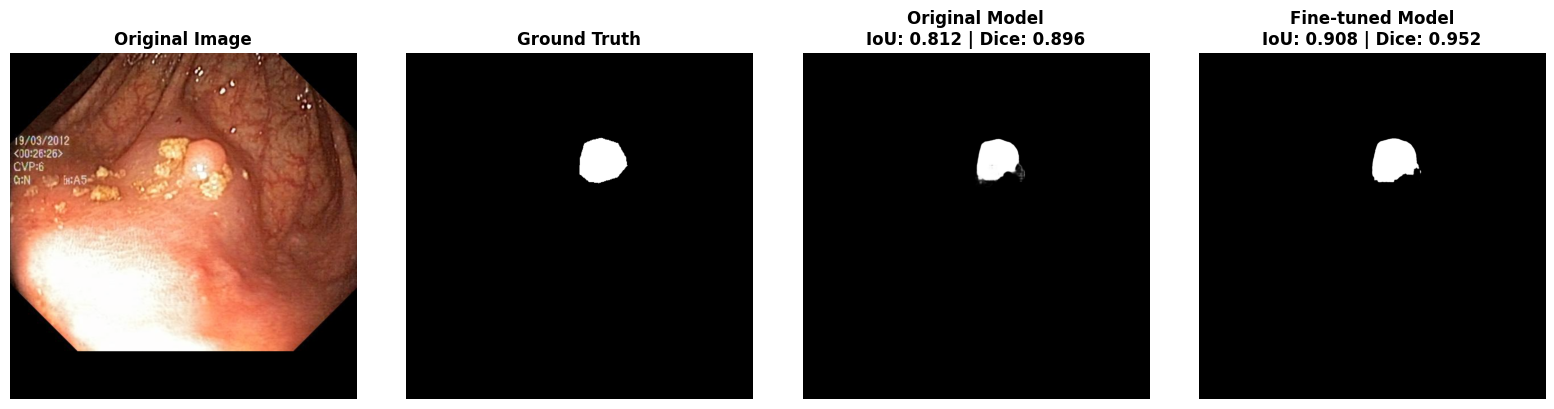

In [1]:
from model.config import Config
from model.dataloaders import prepare_data_splits, create_data_loaders
from model.sam_model import SAMFineTuner
from model.evaluation import compare_models

# Initialize configuration
config = Config()

# Prepare data splits and create test loader
splits = prepare_data_splits(config.DATA_DIR, config.TRAIN_SPLIT, config.VAL_SPLIT)
_, _, test_loader = create_data_loaders(config, splits)

# Create original model (pre-trained, no fine-tuning)
print("Loading original model...")
model_original = SAMFineTuner.create_original(config)

# Load fine-tuned model
print("\nLoading fine-tuned model...")
model_finetuned = SAMFineTuner(config).load('outputs/best_model.pth')

# Compare models
results = compare_models(model_original, model_finetuned, test_loader, show_example=True)

# Comparação Detalhada: Modelo Base vs Modelo com Fine-tuning

Esta seção apresenta uma análise comparativa detalhada entre o modelo pré-treinado (base) e o modelo com fine-tuning, incluindo gráficos comparativos e exemplos em imagens desafiadoras.


In [ ]:
# Gráficos Comparativos
import matplotlib.pyplot as plt
import numpy as np

# Extract metrics from results
metrics = ['Loss', 'IoU', 'Dice']
original_values = [results['original']['loss'], results['original']['iou'], results['original']['dice']]
finetuned_values = [results['finetuned']['loss'], results['finetuned']['iou'], results['finetuned']['dice']]
improvements = [ft - orig for orig, ft in zip(original_values, finetuned_values)]

# Create comparison plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Bar plot comparing metrics
x = np.arange(len(metrics))
width = 0.35

axes[0].bar(x - width/2, original_values, width, label='Modelo Base', color='#FF6B6B', alpha=0.8)
axes[0].bar(x + width/2, finetuned_values, width, label='Modelo Fine-tuned', color='#4ECDC4', alpha=0.8)
axes[0].set_xlabel('Métricas', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Valor', fontsize=12, fontweight='bold')
axes[0].set_title('Comparação de Métricas', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (orig, ft) in enumerate(zip(original_values, finetuned_values)):
    axes[0].text(i - width/2, orig, f'{orig:.4f}', ha='center', va='bottom', fontsize=9)
    axes[0].text(i + width/2, ft, f'{ft:.4f}', ha='center', va='bottom', fontsize=9)

# Improvement plot
colors = ['green' if imp > 0 else 'red' for imp in improvements]
axes[1].barh(metrics, improvements, color=colors, alpha=0.7)
axes[1].axvline(x=0, color='black', linestyle='--', linewidth=1)
axes[1].set_xlabel('Melhoria', fontsize=12, fontweight='bold')
axes[1].set_title('Melhoria do Fine-tuning', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (metric, imp) in enumerate(zip(metrics, improvements)):
    label = f'{imp:+.4f}'
    axes[1].text(imp, i, label, ha='left' if imp > 0 else 'right', va='center', 
                fontsize=10, fontweight='bold')

# Percentage improvement plot
percentage_improvements = [(ft - orig) / orig * 100 for orig, ft in zip(original_values, finetuned_values)]
axes[2].bar(metrics, percentage_improvements, color=['#FF6B6B', '#4ECDC4', '#95E1D3'], alpha=0.8)
axes[2].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[2].set_ylabel('Melhoria Percentual (%)', fontsize=12, fontweight='bold')
axes[2].set_title('Melhoria Percentual', fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3, axis='y')

# Add value labels
for i, (metric, pct) in enumerate(zip(metrics, percentage_improvements)):
    axes[2].text(i, pct, f'{pct:+.2f}%', ha='center', 
                va='bottom' if pct > 0 else 'top', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()


In [ ]:
# Comparação em Múltiplas Imagens (incluindo casos difíceis)
from model.evaluation import calculate_iou, calculate_dice
import random

# Get multiple samples from test loader, including some challenging ones
test_list = list(test_loader)
random.seed(42)  # For reproducibility

# Evaluate all samples to find challenging cases and store all predictions
all_ious_orig = []
all_ious_ft = []
all_cases = []  # Store all cases with predictions

print("Avaliando todas as imagens do conjunto de teste...")
for idx, batch in enumerate(test_list):
    with torch.no_grad():
        model_original.sam.eval()
        model_finetuned.sam.eval()
        
        images = batch['image'].to(model_original.device)
        masks_gt = batch['mask'].to(model_original.device)
        point_coords = batch['point_coords'].to(model_original.device)
        point_labels = batch['point_labels'].to(model_original.device)
        box_coords = batch.get('box_coords', None)
        if box_coords is not None:
            box_coords = box_coords.to(model_original.device)
        
        # Original model prediction
        orig_image_embedding = model_original.sam.image_encoder(images[0:1])
        if model_original.config.USE_BOTH_PROMPTS and model_original.config.USE_BOX_PROMPTS and box_coords is not None:
            orig_points_input = point_coords[0:1]
            orig_labels_input = point_labels[0:1]
            orig_boxes_input = box_coords[0:1]
        elif model_original.config.USE_BOX_PROMPTS and box_coords is not None:
            orig_boxes_input = box_coords[0:1]
            orig_points_input = None
            orig_labels_input = None
        else:
            orig_points_input = point_coords[0:1]
            orig_labels_input = point_labels[0:1]
            orig_boxes_input = None
        
        orig_sparse_embeddings, orig_dense_embeddings = model_original.sam.prompt_encoder(
            points=(orig_points_input, orig_labels_input) if orig_points_input is not None else None,
            boxes=orig_boxes_input,
            masks=None
        )
        orig_low_res_masks, _ = model_original.sam.mask_decoder(
            image_embeddings=orig_image_embedding,
            image_pe=model_original.sam.prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings=orig_sparse_embeddings,
            dense_prompt_embeddings=orig_dense_embeddings,
            multimask_output=False
        )
        orig_upscaled_masks = torch.nn.functional.interpolate(
            orig_low_res_masks,
            size=(model_original.config.IMAGE_SIZE, model_original.config.IMAGE_SIZE),
            mode='bilinear',
            align_corners=False
        )
        orig_pred_mask = torch.sigmoid(orig_upscaled_masks[0, 0]).cpu().numpy()
        
        # Fine-tuned model prediction
        ft_image_embedding = model_finetuned.sam.image_encoder(images[0:1])
        if model_finetuned.config.USE_BOTH_PROMPTS and model_finetuned.config.USE_BOX_PROMPTS and box_coords is not None:
            ft_points_input = point_coords[0:1]
            ft_labels_input = point_labels[0:1]
            ft_boxes_input = box_coords[0:1]
        elif model_finetuned.config.USE_BOX_PROMPTS and box_coords is not None:
            ft_boxes_input = box_coords[0:1]
            ft_points_input = None
            ft_labels_input = None
        else:
            ft_points_input = point_coords[0:1]
            ft_labels_input = point_labels[0:1]
            ft_boxes_input = None
        
        ft_sparse_embeddings, ft_dense_embeddings = model_finetuned.sam.prompt_encoder(
            points=(ft_points_input, ft_labels_input) if ft_points_input is not None else None,
            boxes=ft_boxes_input,
            masks=None
        )
        ft_low_res_masks, _ = model_finetuned.sam.mask_decoder(
            image_embeddings=ft_image_embedding,
            image_pe=model_finetuned.sam.prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings=ft_sparse_embeddings,
            dense_prompt_embeddings=ft_dense_embeddings,
            multimask_output=False
        )
        ft_upscaled_masks = torch.nn.functional.interpolate(
            ft_low_res_masks,
            size=(model_finetuned.config.IMAGE_SIZE, model_finetuned.config.IMAGE_SIZE),
            mode='bilinear',
            align_corners=False
        )
        ft_pred_mask = torch.sigmoid(ft_upscaled_masks[0, 0]).cpu().numpy()
        gt_mask = masks_gt[0, 0].cpu().numpy()
        
        orig_iou = calculate_iou(orig_pred_mask, gt_mask)
        ft_iou = calculate_iou(ft_pred_mask, gt_mask)
        
        all_ious_orig.append(orig_iou)
        all_ious_ft.append(ft_iou)
        
        # Store all cases with predictions
        all_cases.append((idx, batch, orig_pred_mask, ft_pred_mask, gt_mask, orig_iou, ft_iou))

# Identify challenging cases (where original model has low IoU)
challenging_cases = [c for c in all_cases if c[5] < 0.7]
challenging_cases.sort(key=lambda x: x[5])  # Sort by original IoU (lowest first)

# Select cases to visualize: mix of challenging and random
cases_to_show = []
if len(challenging_cases) >= 3:
    # Add 3 most challenging cases
    cases_to_show.extend(challenging_cases[:3])
# Add some random cases from all cases
random_indices = random.sample(range(len(all_cases)), min(3, len(all_cases)))
for idx in random_indices:
    if all_cases[idx] not in cases_to_show:
        cases_to_show.append(all_cases[idx])

# Limit to 6 cases
cases_to_show = cases_to_show[:6]

# Visualize comparisons
fig, axes = plt.subplots(len(cases_to_show), 5, figsize=(20, 4*len(cases_to_show)))

for row, case in enumerate(cases_to_show):
    idx, batch, orig_pred, ft_pred, gt_mask, orig_iou, ft_iou = case
    
    # Denormalize image
    image = batch['image'][0].cpu().permute(1, 2, 0).numpy()
    image = image * [58.395, 57.12, 57.375] + [123.675, 116.28, 103.53]
    image = np.clip(image / 255.0, 0, 1)
    
    # Plot original image
    axes[row, 0].imshow(image)
    axes[row, 0].set_title("Imagem Original", fontsize=11, fontweight='bold')
    axes[row, 0].axis('off')
    
    # Plot ground truth
    axes[row, 1].imshow(gt_mask, cmap='gray')
    axes[row, 1].set_title("Ground Truth", fontsize=11, fontweight='bold')
    axes[row, 1].axis('off')
    
    # Plot original model prediction
    axes[row, 2].imshow(orig_pred, cmap='gray')
    axes[row, 2].set_title(f"Modelo Base\nIoU: {orig_iou:.3f}", fontsize=11, fontweight='bold')
    axes[row, 2].axis('off')
    
    # Plot fine-tuned model prediction
    axes[row, 3].imshow(ft_pred, cmap='gray')
    axes[row, 3].set_title(f"Modelo Fine-tuned\nIoU: {ft_iou:.3f}", fontsize=11, fontweight='bold')
    axes[row, 3].axis('off')
    
    # Plot difference/overlay
    diff = np.abs(ft_pred - orig_pred)
    axes[row, 4].imshow(diff, cmap='hot')
    improvement = ft_iou - orig_iou
    color = 'green' if improvement > 0 else 'red'
    axes[row, 4].set_title(f"Diferença\nMelhoria: {improvement:+.3f}", 
                          fontsize=11, fontweight='bold', color=color)
    axes[row, 4].axis('off')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*60)
print("ESTATÍSTICAS DE COMPARAÇÃO")
print("="*60)
print(f"IoU Médio - Modelo Base: {np.mean(all_ious_orig):.4f} ± {np.std(all_ious_orig):.4f}")
print(f"IoU Médio - Modelo Fine-tuned: {np.mean(all_ious_ft):.4f} ± {np.std(all_ious_ft):.4f}")
print(f"Melhoria Média: {np.mean(all_ious_ft) - np.mean(all_ious_orig):.4f}")
print(f"Casos Desafiadores Identificados: {len(challenging_cases)}")
if len(challenging_cases) > 0:
    print(f"IoU Médio em Casos Difíceis - Base: {np.mean([c[5] for c in challenging_cases]):.4f}")
    print(f"IoU Médio em Casos Difíceis - Fine-tuned: {np.mean([c[6] for c in challenging_cases]):.4f}")
print("="*60)
